# Lens Protocol 分析

- 查詢官網得到 big query 搜索資料集
    - https://lens.xyz/docs/protocol/bigquery/introduction
- 以下是相關定義
    - https://lens.xyz/docs/protocol/bigquery/schemas
    - https://lens.xyz/docs/chain/tools/bigquery/schemas

因為這是 L2 chain, L1 chain 上不會有資料讓我們抓，所以只能 base on L2 chain 官方提供的數據分析

## 我認知中的 Lens Protocol

分成 Polygon 時代和 L2 Lens 時代，分別是借用 Polygon 公鏈運作還有自建 ETH L2 Lens chain 兩個時代

- polygon 時代地址: `0xdb46d1dc155634fbc732f92e853b10b288ad5a1d`
- ETH 時代地址: https://lens.xyz/docs/chain/resources/contracts

以下關注 ETH L2 時代分析

使用者可以用 address 創建 account，account 可以用來操作 Lens 的各種 NFTs

例如:

- post
- username
- curation
- ...

本質上就是把 chain 當 backend 實作一個社群平台

address 是支援 EVM 的地址，可以用來操作 account, post, ... 是操作介面




## 分析
- 总用户数量
- 总的创作者数量
- 创作者占比等

In [16]:
from datetime import datetime

import pandas as pd

# use below code in big query to get raw data about all user
#########################################
# SELECT address, creatorTxHash, creatorAddress FROM `lens-chain-mainnet.public.addresses`
#########################################
# use below code in big query to get creator in lens (在 lens protocol 中持有 account 的人就是創作者, 可以視為真實的人)
#########################################
# SELECT account, name FROM `lens-protocol-mainnet.account.metadata`
#########################################

data1 = pd.read_json("bq-results-20251214-020723-1765649391598.json", lines=True)
# 總用戶數 (address 是操作介面總數, 不等於真正用戶, 但可以視為總用戶數)
print(data1['address'].nunique()) # 835637

data2 = pd.read_json("bq-results-20251214-171412-1765732479868.json", lines=True)
# 總創作者數量 (可以實際顯示的用戶，比少於操作介面 address, 更接近真實用戶數量)
print(data2['account'].nunique()) # 519065

## 占比
print(data2['account'].nunique()/data1['address'].nunique())

835637
519065
0.62116086291057


關於 POST 的資料

- 总出版物数量
- 总评论数量、
- 总镜像数量、
- 总收藏数量等

In [17]:
import pandas as pd

# use below code in big query to get raw data about post
#########################################
# SELECT post, total_amount_of_comments, total_amount_of_collects, total_amount_of_reposts FROM `lens-protocol-mainnet.post.summary
#########################################

data = pd.read_json("bq-results-20251215-013613-1765733803766.json", lines=True)
# 總數
print(data['post'].nunique()) # 2302252
# 留言
print(data['total_amount_of_comments'].sum())
# 重 po (鏡向)
print(data['total_amount_of_reposts'].sum())
# 收藏
print(data['total_amount_of_collects'].sum())


2302252
5349338
1190266
367285


分析 account 使用

- 用户相关的分析：
    - 每日新增创作者数量、
    - 活跃创作者数量、

                account  created_on
created_on_day                     
2025-11-17          118         118
2025-11-18           96          96
2025-11-19           82          82
2025-11-20           66          66
2025-11-21          102         102
2025-11-22           49          49
2025-11-23           67          67
2025-11-24           97          97
2025-11-25           78          78
2025-11-26           59          59
2025-11-27           46          46
2025-11-28           54          54
2025-11-29           59          59
2025-11-30           46          46
2025-12-01           54          54
2025-12-02           78          78
2025-12-03           78          78
2025-12-04          109         109
2025-12-05           71          71
2025-12-06           41          41
2025-12-07           41          41
2025-12-08           63          63
2025-12-09           59          59
2025-12-10           74          74
2025-12-11           58          58
2025-12-12           71     

<Axes: >

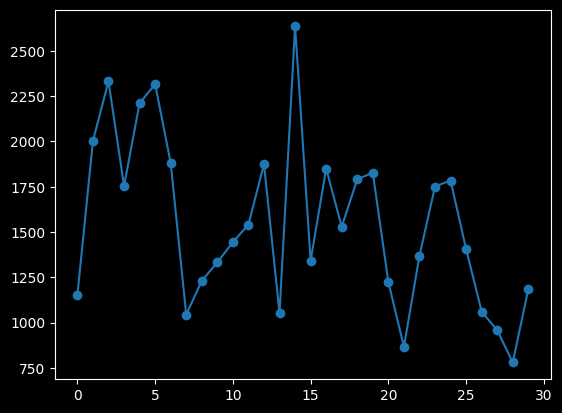

In [18]:

# use below code in big query to get new account in month
#########################################
# SELECT account, created_on
# FROM `lens-protocol-mainnet.account.metadata`
# WHERE
#   TIMESTAMP_TRUNC(_airbyte_extracted_at, DAY) > TIMESTAMP("2025-11-16")
#   AND
#   TIMESTAMP_TRUNC(_airbyte_extracted_at, DAY) < TIMESTAMP("2025-12-16")
#########################################

data = pd.read_json("bquxjob_6796cdd0_19b22ce1515.json")
data['created_on_day'] = pd.to_datetime(data['created_on'], errors='raise').dt.date
data = data.groupby(['created_on_day']).count()
print(data)
print(data.dtypes)
# data['account'].plot(
#     kind='line',
#     marker='o',
#     title='Daily New Account Creation Trend'
# )

# 把當天有 post貼文 quote引用 repost轉發 collect收藏 comment留言 reaction按讚: 視為活躍用戶
# 但資料集不全: 把 post record 和 reaction 當作活躍
#########################################
# SELECT
#     action_date,
#     COUNT(DISTINCT active_account) AS daily_active_users_count
# FROM
#     (
#         -- 貼文活動：將 timestamp 截斷為 DATE
#         SELECT
#             account AS active_account,
#             DATE(timestamp) AS action_date -- 截斷到 Day
#         FROM
#             `lens-protocol-mainnet.post.record`
#         WHERE
#             timestamp >= TIMESTAMP("2025-11-16")
#             AND timestamp < TIMESTAMP("2025-12-16")
#
#         UNION DISTINCT
#
#         -- 反應活動：將 action_at 截斷為 DATE
#         SELECT
#             account AS active_account,
#             DATE(action_at) AS action_date -- 截斷到 Day
#         FROM
#             `lens-protocol-mainnet.post.reaction`
#         WHERE
#             action_at >= TIMESTAMP("2025-11-16")
#             AND action_at < TIMESTAMP("2025-12-16")
#     )
# GROUP BY
#     action_date
# ORDER BY
#     action_date
#########################################

df = pd.read_json("bquxjob_78a30955_19b248c0c74.json")
df['action_date'] = pd.to_datetime(df['action_date'])
df['daily_active_users_count'] = df['daily_active_users_count'].astype(int)

# 繪製折線圖
df['daily_active_users_count'].plot(
    kind='line',
    marker='o',
    linestyle='-',
    color='tab:blue'
)

- Lens账号个性化域名的相关分析：
    - 域名注册数量、
    - 不同类型域名的注册情况（纯数字、纯字母、不同长度）等

In [19]:
import numpy as np

# use below code in big query to get creator's domain name without empty
#########################################
# SELECT account, name
# FROM `lens-protocol-mainnet.account.metadata`
# WHERE
#   name != "Temporary Name"
#   AND
#   name != ""
#########################################

df = pd.read_json("bq-results-20251216-211012-1765890668230.json", lines=True)
# 數量
print(df.count())

# 各類域名
is_pure_digit = df['name'].str.match(r'^\d+$')
is_pure_alpha = df['name'].str.match(r'^[a-zA-Z]+$')
has_chinese = df['name'].str.contains(r'[\u4e00-\u9fa5]', regex=True)
has_special_char = df['name'].str.contains(r'[^a-zA-Z0-9\u4e00-\u9fa5]', regex=True)

conditions = [
    is_pure_digit,
    is_pure_alpha,
    has_chinese,
    has_special_char
]

choices = [
    '純數字',
    '純字母',
    '包含中文',
    '包含特殊符號'
]

df['type'] = np.select(conditions, choices, default='混合/其他')
print(df.head())
print(df.groupby(['type']).count())
print(df[df["type"] == "混合/其他"])


account    431410
name       431410
dtype: int64
                                      account                name    type
0  \x22d36a9094b56de2fe8c8a97613f23529c16ccc3               Chief     純字母
1  \x2c326e07c56bbd62a2e2b3c4ae770c7d47443846  USMAN ADAMU MADARA  包含特殊符號
2  \xf288d4f1d48f877981dd10472f3ca03d4a9f920e                 ann     純字母
3  \x03ffab05e04cc2d524a642308e04e70318a36a7f                 测别的    包含中文
4  \xf3df668b8d0ace070692c1f73dbf5d9abdc4b54f        News by Vecs  包含特殊符號
        account    name
type                   
包含中文       4031    4031
包含特殊符號    88841   88841
混合/其他     63923   63923
純字母      270603  270603
純數字        4012    4012
                                           account        name   type
6       \x2ec29ee2301cc4bcdb7c3d848ec31ab3e737266e      ni1123  混合/其他
8       \x57737e28fd1fa0b2147c5a9e17153d016a765ac1     dudu100  混合/其他
9       \x978db75b7e7757f55521a67a43df6ff0cca80737     dudu123  混合/其他
11      \xd7cce2ef7dd99e0ba0cedecd0ddd033dfec19224    dudu1

### 同一個地址創建多個 Profile 分析

要抓出是否由單一 address 管理多個 account

In [20]:
# use below code in big query to get account manager (address can control account)
#########################################
# SELECT manager, COUNT(manager)
# FROM `lens-protocol-mainnet.account.manager`
# group by manager
# HAVING COUNT(manager) > 1
#########################################

df = pd.read_json("bquxjob_595970c_19b2763fc40.json", lines=False)
print(df.head())

                                      manager  f0_
0  \x43624fb09ccbc35e8d97ec30fb42b5ebaafc587d    4
1  \x535e99221b7d74468dccb4408f8e79490f55bed2    2
2  \x8cef535cb674958d606dae71c6976c4e98a53594    2
3  \x6a0b2c3b8f061bd249eb7006385c42b2fbab945e    2
4  \xa85dc11b406906a2986ea2bc8c2be38b2e1722bc    2


### 帳號分析

發帖最多的帳號數據分析

In [21]:
# use below code in big query to get post count (sorted)
#########################################
# SELECT account, total_posts FROM `lens-protocol-mainnet.account.post_summary` ORDER BY total_posts DESC
#########################################

df = pd.read_json("bquxjob_55c50c46_19b276cbd0c.json", lines=False)
print(df.head())

                                      account  total_posts
0  \x55796e679e84571b5d9839ca3452dd95a53cf362       521147
1  \x17231bb262dfa16ca4f7dab2151cb7e9aad7fdb9       334359
2  \xd6f76d99bbbae7bed872005697d09ac6300dcef1        83955
3  \x4e473118557e2b26486e8e57b3b7f9aa5d9276c4        68811
4  \x8362fea1864d5f6e33b7ed91186767a0943f71c2        54944
